# 기본 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [4]:
# 오차행렬 및 평가지표 출력
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


# 임계값 조정하여 오차행렬 및 평가지표 출력
def get_eval_by_threshold(y_test, pred, pred_proba_c1, thresholds):
    pred_proba_c1 = pred_proba_c1.reshape(-1, 1)
    for custom_threshold in thresholds:
        bina = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = bina.transform(pred_proba_c1)
        print('분류 임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
    

# 임계값별로 precison_recall_curve 그리기
def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]

    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [5]:
def dict_to_params(model, params_dict):
    for key, value in params_dict.items():
        eval(f"model.set_params({key}=value)")
    return model


def grid_search_eval(model, params):
    model_list = []
    
    gs = GridSearchCV(estimator=model, param_grid=params, scoring=["accuracy", "f1", "recall", "precision"], 
                      refit=False, cv=3, verbose=2)
    gs.fit(X_train, y_train)
    
    result = pd.DataFrame(gs.cv_results_)
    
    best_results = result[(result["rank_test_accuracy"]<=3) | (result["rank_test_f1"]<=3) | 
                          (result["rank_test_recall"]<=3) | (result["rank_test_precision"]<=3)]
    
    for best_params in best_results["params"]:
        model_list.append(dict_to_params(copy.deepcopy(model), best_params))
    
    for best_model in model_list:
        best_model.fit(X_train, y_train)

        pred = best_model.predict(X_test)
        pred_proba = best_model.predict_proba(X_test)[:,1]

        print("="*100, "\n", best_model)
        print(best_model.score(X_train, y_train))
        print(best_model.score(X_test, y_test))
        get_clf_eval(y_test, pred, pred_proba)
    
    return model_list, result

## 데이터 준비

In [6]:
def prepare_data():
    brfss = pd.read_csv("/content/drive/MyDrive/multicampus/data/brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(y_train.value_counts())
    
    return X_train, X_test, y_train, y_test

In [30]:
def prepare_data_no():
    brfss = pd.read_csv("/content/drive/MyDrive/multicampus/data/brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    
    return X_train, X_test, y_train, y_test

# 할 일
- 하이퍼 파라미터 튜닝
    - 각 모델 document 보면서 찾아보기
- 임계점 변경
    - 변경해보면서 최적값 찾기

# 박민정

## Data
- 건강검진 데이터의 KIDNEY 조건 변경 검토
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 or x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8 else 0, axis=1)
0    1295062
1     744182
```
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 and (x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8) else 0, axis=1)
0    2020722
1      18522
```

## DecisionTree

### base model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7102965380645522
0.6601743034464546
오차 행렬
[[46873 24775]
 [  960  3122]]
정확도: 0.6602, 정밀도: 0.1119, 재현율: 0.7648, F1: 0.1953, AUC:0.7723


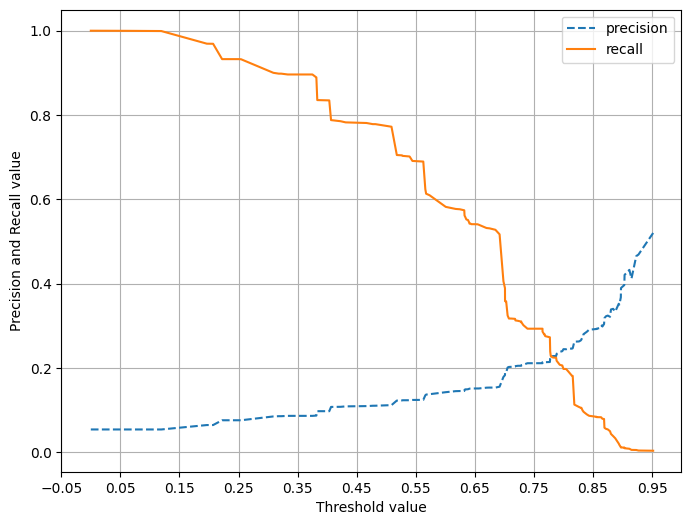

In [ ]:
# 임계값 그래프
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
# 임계값 조정
thresholds = [.5, .55, .6, .65, .7, .75, .8, .85]
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)

분류 임계값 : 0.5
오차 행렬
[[46634 25032]
 [  926  3138]]
정확도: 0.6572, 정밀도: 0.1114, 재현율: 0.7721, F1: 0.1947, AUC:0.7744
분류 임계값 : 0.55
오차 행렬
[[51845 19821]
 [ 1262  2802]]
정확도: 0.7216, 정밀도: 0.1239, 재현율: 0.6895, F1: 0.2100, AUC:0.7744
분류 임계값 : 0.6
오차 행렬
[[57391 14275]
 [ 1699  2365]]
정확도: 0.7891, 정밀도: 0.1421, 재현율: 0.5819, F1: 0.2285, AUC:0.7744
분류 임계값 : 0.65
오차 행렬
[[59311 12355]
 [ 1867  2197]]
정확도: 0.8122, 정밀도: 0.1510, 재현율: 0.5406, F1: 0.2360, AUC:0.7744
분류 임계값 : 0.7
오차 행렬
[[64586  7080]
 [ 2483  1581]]
정확도: 0.8737, 정밀도: 0.1825, 재현율: 0.3890, F1: 0.2485, AUC:0.7744
분류 임계값 : 0.75
오차 행렬
[[67214  4452]
 [ 2874  1190]]
정확도: 0.9033, 정밀도: 0.2109, 재현율: 0.2928, F1: 0.2452, AUC:0.7744
분류 임계값 : 0.8
오차 행렬
[[69185  2481]
 [ 3263   801]]
정확도: 0.9242, 정밀도: 0.2441, 재현율: 0.1971, F1: 0.2181, AUC:0.7744
분류 임계값 : 0.85
오차 행렬
[[70842   824]
 [ 3724   340]]
정확도: 0.9399, 정밀도: 0.2921, 재현율: 0.0837, F1: 0.1301, AUC:0.7744


### 모델링
- 하이퍼 파라미터    
    - criterion: {“gini”, “entropy”, “log_loss”}, default=”gini”
    - splitter: {“best”, “random”}, default=”best”
    - max_depth: int, default=None
    - min_samples_split: int or float, default=2
    - min_samples_leaf: int or float, default=1
    - min_weight_fraction_leaf: float, default=0.0
    - max_features: int, float or {“auto”, “sqrt”, “log2”}, default=None
    - random_state: int, RandomState instance or None, default=None
    - max_leaf_nodes: int, default=None
    - min_impurity_decrease: float, default=0.0
    - class_weight: dict, list of dict or “balanced”, default=None
    - ccp_alpha: non-negative float, default=0.0

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

#### 트리 관련

In [14]:
params = {
    "max_depth": [1, 5, 10],
    "min_samples_split": [2, 22, 42],
    "min_samples_leaf": [1, 5, 10],
    "min_impurity_decrease": [0.0001, 0.0005, 0.001],
    "ccp_alpha": [0.0, 0.02, 0.04],
}

X_train, X_test, y_train, y_test = prepare_data()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, params)

0.0    286740
1.0    286740
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=22; total time=   0.5s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=22; total time=   0.5s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=22; total time=   0.5s
[CV] END ccp_alpha=0.0, max_depth=1, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=42; to

In [26]:
for col in result.columns:
  if col.startswith("param_"):
    print(result.groupby(col).mean()[["rank_test_precision"]])

                 rank_test_precision
param_ccp_alpha                     
0.00                            33.0
0.02                            55.0
0.04                            55.0
                 rank_test_precision
param_max_depth                     
1                               55.0
5                               41.0
10                              47.0
                             rank_test_precision
param_min_impurity_decrease                     
0.0001                                      47.0
0.0005                                      51.0
0.0010                                      45.0
                        rank_test_precision
param_min_samples_leaf                     
1                                 47.666667
5                                 47.666667
10                                47.666667
                         rank_test_precision
param_min_samples_split                     
2                                  47.666667
22                            

In [29]:
params = {
    "max_depth": [5, 6, 7, 8, 9, 10],
    "min_impurity_decrease": [.0001, .0003, .0005, .0007, .0009, .001],
    "ccp_alpha": [.0, .01, .02],
}

X_train, X_test, y_train, y_test = prepare_data()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, params)

0.0    286702
1.0    286702
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0001; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0001; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0001; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0003; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0003; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0003; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0005; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0005; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0005; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=5, min_impurity_decrease=0.0007; total time=   0.7s
[CV] END ccp_alp

In [33]:
params = {
    "max_depth": [1, 5, 10, 15, 20],
    # "min_impurity_decrease": [.0001, .0003, .0005, .0007, .0009, .001],
    # "ccp_alpha": [.0, .01, .02],
}

X_train, X_test, y_train, y_test = prepare_data_no()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=1; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=5; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=5; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ........................................max_depth=5; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .......................................max_depth=10; total time=   0.3s
[CV] END .......................................max_depth=10; total time=   0.3s
[CV] END .......................................max_depth=10; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .......................................max_depth=15; total time=   0.3s
[CV] END .......................................max_depth=15; total time=   0.3s
[CV] END .......................................max_depth=15; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .......................................max_depth=20; total time=   0.3s
[CV] END .......................................max_depth=20; total time=   0.3s
[CV] END .......................................max_depth=20; total time=   0.3s
 DecisionTreeClassifier(max_depth=1)
0.946681588295105
0.9462432325366433


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


오차 행렬
[[71659     0]
 [ 4071     0]]
정확도: 0.9462, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC:0.6789
 DecisionTreeClassifier(max_depth=5)
0.946681588295105
0.9462432325366433


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


오차 행렬
[[71659     0]
 [ 4071     0]]
정확도: 0.9462, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC:0.7645
 DecisionTreeClassifier(max_depth=10)
0.9466947932760237
0.9462960517628417
오차 행렬
[[71649    10]
 [ 4057    14]]
정확도: 0.9463, 정밀도: 0.5833, 재현율: 0.0034, F1: 0.0068, AUC:0.7723
 DecisionTreeClassifier(max_depth=15)
0.9466947932760237
0.9462960517628417
오차 행렬
[[71649    10]
 [ 4057    14]]
정확도: 0.9463, 정밀도: 0.5833, 재현율: 0.0034, F1: 0.0068, AUC:0.7723
 DecisionTreeClassifier(max_depth=20)
0.9466947932760237
0.9462960517628417
오차 행렬
[[71649    10]
 [ 4057    14]]
정확도: 0.9463, 정밀도: 0.5833, 재현율: 0.0034, F1: 0.0068, AUC:0.7723


#### 전체 

In [ ]:
all_params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"], 
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None],
    "max_depth": #########################################,
    "min_impurity_decrease": #########################################,
    "ccp_alpha": #########################################,
    
    # "min_samples_split": 1, 5, 10에서 차이 X
    # "min_samples_leaf": 2, 22, 42에서 차이 X
}

X_train, X_test, y_train, y_test = prepare_data()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, all_params)

0.0    286732
1.0    286732
Name: HEARTDISEASE, dtype: int64


### 임계값 변경
- 의료 데이터이므로 높이는 쪽으로

## SGDClassifier
- 하이퍼 파라미터
    - loss: {‘hinge’, ‘log_loss’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, ‘squared_epsilon_insensitive’}, default=’hinge’
    - penalty: {‘l2’, ‘l1’, ‘elasticnet’, None}, default=’l2’
    - alpha: float, default=0.0001
    - l1_ratio: float, default=0.15
    - fit_intercept: bool, default=True
    - max_iter: int, default=1000
    - tol: float or None, default=1e-3
    - verbose: int, default=0
    - epsilon: float, default=0.1
    - n_jobs: int, default=None
    - learning_rate: str, default=’optimal’
    - eta0: float, default=0.0
    - power_t: float, default=0.5
    - early_stopping: bool, default=False
    - validation_fraction: float, default=0.1
    - n_iter_no_change: int, default=5
    - class_weight: dict, {class_label: weight} or “balanced”, default=None
    - warm_start: bool, default=False
    - average: bool or int, default=False
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="log_loss", max_iter=10)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7078343826848283
0.6706589198468242
오차 행렬
[[47835 23904]
 [ 1037  2954]]
정확도: 0.6707, 정밀도: 0.1100, 재현율: 0.7402, F1: 0.1915, AUC:0.7691


## SVM
- 종류
    - SVC
    - LinearSVC
    - NuSVC
    - https://scikit-learn.org/stable/modules/svm.html#svm-classification
- SVC 하이퍼 파라미터
    - C: float, default=1.0
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False
- NuSVC 하이퍼 파라미터
    - nu: float, default=0.5
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False
- LinearSVC 하이퍼 파라미터
    - penalty: {‘l1’, ‘l2’}, default=’l2’
    - loss: {‘hinge’, ‘squared_hinge’}, default=’squared_hinge’
    - dual: bool, default=True
    - tol: float, default=1e-4
    - C: float, default=1.0
    - multi_class: {‘ovr’, ‘crammer_singer’}, default=’ovr’
    - fit_intercept: bool, default=True
    - intercept_scaling: float, default=1.0
    - class_weight: dict or ‘balanced’, default=None
    - verbose: int, default=0
    - random_state: int, RandomState instance or None, default=None
    - max_iter: int, default=1000

In [ ]:
from sklearn.svm import SVC, LinearSVC, NuSVC

model = SVC(max_iter=100, probability=True)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5499741942683377
0.5574144988775914
오차 행렬
[[40074 31592]
 [ 1925  2139]]
정확도: 0.5574, 정밀도: 0.0634, 재현율: 0.5263, F1: 0.1132, AUC:0.5000


In [ ]:
model = LinearSVC(max_iter=100)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7064789822777394
0.6724943879572164


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
model = NuSVC(max_iter=100, probability=True)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

# 서대훈

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

-2.8939165652334635

## LightGBM 

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7105471419208189
0.656410933579823
오차 행렬
[[46554 25034]
 [  986  3156]]
정확도: 0.6564, 정밀도: 0.1120, 재현율: 0.7620, F1: 0.1952, AUC:0.7700


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7105211755924352
0.6586293410801531
오차 행렬
[[46843 24883]
 [  969  3035]]
정확도: 0.6586, 정밀도: 0.1087, 재현율: 0.7580, F1: 0.1902, AUC:0.7665


# 손지호

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[47869 23870]
 [ 1042  2949]]
정확도: 0.6710, 정밀도: 0.1100, 재현율: 0.7389, F1: 0.1914, AUC:0.7695


## XGBClassifier

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

0.7105453987644508
0.6563977287732735
오차 행렬
[[46552 25036]
 [  985  3157]]
정확도: 0.6564, 정밀도: 0.1120, 재현율: 0.7622, F1: 0.1953, AUC:0.7698


## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)